## Create ML model using RANDOM FOREST algorithm for self-driving car with LIDAR data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## 1. Loading the data

In [ ]:
# read data from csv
data = pd.read_csv('./corrected_data.txt', header=None)
data.shape

(589, 361)

In [ ]:
# Take a look at the dataframe
data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,0.00,615.50,591.5,0.00,569.25,549.75,0.00,532.00,516.00,0.00,...,800.50,0.00,784.25,0.00,753.0,710.50,0.00,675.75,643.00,0.00
1,0.00,680.25,0.0,648.75,619.25,0.00,595.25,572.25,0.00,552.25,...,932.00,0.00,906.00,805.00,791.0,0.00,775.00,759.50,716.50,-0.20
2,0.00,879.75,0.0,857.75,836.75,0.00,818.50,802.00,783.25,0.00,...,1163.75,1134.25,0.00,1015.50,0.0,0.00,956.00,927.00,904.25,0.20
3,1016.75,0.00,1002.5,975.50,0.00,944.25,915.50,0.00,890.00,866.25,...,1109.75,1082.50,1109.50,0.00,0.0,0.00,0.00,1051.25,1037.25,0.38
4,0.00,898.25,0.0,870.00,842.50,0.00,819.25,796.50,0.00,776.50,...,0.00,940.50,1009.00,990.25,0.0,974.75,958.25,945.75,929.75,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,736.25,0.00,725.0,709.25,698.00,0.00,687.00,676.00,0.00,0.00,...,986.75,0.00,0.00,803.75,0.0,785.50,768.75,0.00,751.75,0.40
585,0.00,822.75,0.0,801.25,781.25,0.00,761.25,745.50,728.50,0.00,...,0.00,923.00,0.00,967.50,0.0,937.50,904.25,875.00,848.00,0.20
586,0.00,717.00,0.0,698.25,681.50,0.00,666.50,652.50,0.00,639.00,...,769.00,744.25,0.00,835.25,0.0,806.50,781.50,757.00,735.50,0.00
587,0.00,572.00,564.0,0.00,553.00,0.00,545.00,537.25,530.00,0.00,...,592.75,580.75,0.00,568.50,624.0,0.00,610.00,596.00,584.75,-0.50


## 2. Data Preprocessing

In [ ]:
# Impute value of 0, Makeup data with 0 distance the average of 2 adjacent values
def cleanup_zero_distances(data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - 1): # skip the last column as it is the Turn value
            if data.iloc[i, j] == 0:
                # get right side value
                k = j # set column position at j
                left_val = right_val = 0
                while k < data.shape[1]: # keep finding until found non zero value
                    if data.iloc[i, k] > 0:
                        right_val = data.iloc[i, k]
                        break
                    k = k + 1
                # get the left side value
                left_val = right_val
                k = j # set column position at j
                while k >= 0: # keep finding until found non zero value
                    if data.iloc[i, k] > 0:
                        left_val = data.iloc[i, k]
                        break
                    k = k - 1
                data.iat[i, j] = (left_val + right_val) / 2
cleanup_zero_distances(data)
data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,615.50,615.500,591.500,580.375,569.250,549.750,540.875,532.00,516.00,507.875,...,800.500,792.375,784.250,768.625,753.0000,710.50000,693.125000,675.750,643.00,0.00
1,680.25,680.250,664.500,648.750,619.250,607.250,595.250,572.25,562.25,552.250,...,932.000,919.000,906.000,805.000,791.0000,783.00000,775.000000,759.500,716.50,-0.20
2,879.75,879.750,868.750,857.750,836.750,827.625,818.500,802.00,783.25,776.625,...,1163.750,1134.250,1074.875,1015.500,985.7500,970.87500,956.000000,927.000,904.25,0.20
3,1016.75,1009.625,1002.500,975.500,959.875,944.250,915.500,902.75,890.00,866.250,...,1109.750,1082.500,1109.500,1080.375,1065.8125,1058.53125,1054.890625,1051.250,1037.25,0.38
4,898.25,898.250,884.125,870.000,842.500,830.875,819.250,796.50,786.50,776.500,...,947.875,940.500,1009.000,990.250,982.5000,974.75000,958.250000,945.750,929.75,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,736.25,730.625,725.000,709.250,698.000,692.500,687.000,676.00,661.25,653.875,...,986.750,895.250,849.500,803.750,794.6250,785.50000,768.750000,760.250,751.75,0.40
585,822.75,822.750,812.000,801.250,781.250,771.250,761.250,745.50,728.50,721.000,...,923.875,923.000,945.250,967.500,952.5000,937.50000,904.250000,875.000,848.00,0.20
586,717.00,717.000,707.625,698.250,681.500,674.000,666.500,652.50,645.75,639.000,...,769.000,744.250,789.750,835.250,820.8750,806.50000,781.500000,757.000,735.50,0.00
587,572.00,572.000,564.000,558.500,553.000,549.000,545.000,537.25,530.00,526.250,...,592.750,580.750,574.625,568.500,624.0000,617.00000,610.000000,596.000,584.75,-0.50


In [ ]:
# get augmented data
def get_augmented_data(data):
    augmented_data = np.zeros(data.shape)
    for i in range(augmented_data.shape[0]):
        for j in range(augmented_data.shape[1]):
            augmented_data[i, j] = data.iloc[i, 359 - j]
        augmented_data[i, 360] = round(0 - float(data.iloc[i, 360]),2)

    return pd.DataFrame(augmented_data)
augmented_data = get_augmented_data(data)
augmented_data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,643.00,675.750,693.125000,710.50000,753.0000,768.625,784.250,792.375,800.500,816.250,...,516.00,532.00,540.875,549.750,569.250,580.375,591.500,615.500,615.50,0.00
1,716.50,759.500,775.000000,783.00000,791.0000,805.000,906.000,919.000,932.000,956.750,...,562.25,572.25,595.250,607.250,619.250,648.750,664.500,680.250,680.25,0.20
2,904.25,927.000,956.000000,970.87500,985.7500,1015.500,1074.875,1134.250,1163.750,1004.125,...,783.25,802.00,818.500,827.625,836.750,857.750,868.750,879.750,879.75,-0.20
3,1037.25,1051.250,1054.890625,1058.53125,1065.8125,1080.375,1109.500,1082.500,1109.750,953.000,...,890.00,902.75,915.500,944.250,959.875,975.500,1002.500,1009.625,1016.75,-0.38
4,929.75,945.750,958.250000,974.75000,982.5000,990.250,1009.000,940.500,947.875,955.250,...,786.50,796.50,819.250,830.875,842.500,870.000,884.125,898.250,898.25,-0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,751.75,760.250,768.750000,785.50000,794.6250,803.750,849.500,895.250,986.750,984.750,...,661.25,676.00,687.000,692.500,698.000,709.250,725.000,730.625,736.25,-0.40
585,848.00,875.000,904.250000,937.50000,952.5000,967.500,945.250,923.000,923.875,924.750,...,728.50,745.50,761.250,771.250,781.250,801.250,812.000,822.750,822.75,-0.20
586,735.50,757.000,781.500000,806.50000,820.8750,835.250,789.750,744.250,769.000,783.000,...,645.75,652.50,666.500,674.000,681.500,698.250,707.625,717.000,717.00,0.00
587,584.75,596.000,610.000000,617.00000,624.0000,568.500,574.625,580.750,592.750,599.000,...,530.00,537.25,545.000,549.000,553.000,558.500,564.000,572.000,572.00,0.50


In [ ]:
appended_df = pd.concat([data, augmented_data], ignore_index=True)
appended_df.rename(columns={appended_df.columns[-1]: 'Turn'}, inplace=True)
appended_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,Turn
0,615.50,615.500,591.500,580.375,569.250,549.750,540.875,532.00,516.000,507.875,...,800.500,792.375,784.250,768.625,753.0000,710.50000,693.125000,675.750,643.00,0.00
1,680.25,680.250,664.500,648.750,619.250,607.250,595.250,572.25,562.250,552.250,...,932.000,919.000,906.000,805.000,791.0000,783.00000,775.000000,759.500,716.50,-0.20
2,879.75,879.750,868.750,857.750,836.750,827.625,818.500,802.00,783.250,776.625,...,1163.750,1134.250,1074.875,1015.500,985.7500,970.87500,956.000000,927.000,904.25,0.20
3,1016.75,1009.625,1002.500,975.500,959.875,944.250,915.500,902.75,890.000,866.250,...,1109.750,1082.500,1109.500,1080.375,1065.8125,1058.53125,1054.890625,1051.250,1037.25,0.38
4,898.25,898.250,884.125,870.000,842.500,830.875,819.250,796.50,786.500,776.500,...,947.875,940.500,1009.000,990.250,982.5000,974.75000,958.250000,945.750,929.75,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,751.75,760.250,768.750,785.500,794.625,803.750,849.500,895.25,986.750,984.750,...,661.250,676.000,687.000,692.500,698.0000,709.25000,725.000000,730.625,736.25,-0.40
1174,848.00,875.000,904.250,937.500,952.500,967.500,945.250,923.00,923.875,924.750,...,728.500,745.500,761.250,771.250,781.2500,801.25000,812.000000,822.750,822.75,-0.20
1175,735.50,757.000,781.500,806.500,820.875,835.250,789.750,744.25,769.000,783.000,...,645.750,652.500,666.500,674.000,681.5000,698.25000,707.625000,717.000,717.00,0.00
1176,584.75,596.000,610.000,617.000,624.000,568.500,574.625,580.75,592.750,599.000,...,530.000,537.250,545.000,549.000,553.0000,558.50000,564.000000,572.000,572.00,0.50


In [ ]:
X = appended_df.iloc[:, :-1]
X

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,615.50,615.500,591.500,580.375,569.250,549.750,540.875,532.00,516.000,507.875,...,816.250,800.500,792.375,784.250,768.625,753.0000,710.50000,693.125000,675.750,643.00
1,680.25,680.250,664.500,648.750,619.250,607.250,595.250,572.25,562.250,552.250,...,956.750,932.000,919.000,906.000,805.000,791.0000,783.00000,775.000000,759.500,716.50
2,879.75,879.750,868.750,857.750,836.750,827.625,818.500,802.00,783.250,776.625,...,1004.125,1163.750,1134.250,1074.875,1015.500,985.7500,970.87500,956.000000,927.000,904.25
3,1016.75,1009.625,1002.500,975.500,959.875,944.250,915.500,902.75,890.000,866.250,...,953.000,1109.750,1082.500,1109.500,1080.375,1065.8125,1058.53125,1054.890625,1051.250,1037.25
4,898.25,898.250,884.125,870.000,842.500,830.875,819.250,796.50,786.500,776.500,...,955.250,947.875,940.500,1009.000,990.250,982.5000,974.75000,958.250000,945.750,929.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,751.75,760.250,768.750,785.500,794.625,803.750,849.500,895.25,986.750,984.750,...,653.875,661.250,676.000,687.000,692.500,698.0000,709.25000,725.000000,730.625,736.25
1174,848.00,875.000,904.250,937.500,952.500,967.500,945.250,923.00,923.875,924.750,...,721.000,728.500,745.500,761.250,771.250,781.2500,801.25000,812.000000,822.750,822.75
1175,735.50,757.000,781.500,806.500,820.875,835.250,789.750,744.25,769.000,783.000,...,639.000,645.750,652.500,666.500,674.000,681.5000,698.25000,707.625000,717.000,717.00
1176,584.75,596.000,610.000,617.000,624.000,568.500,574.625,580.75,592.750,599.000,...,526.250,530.000,537.250,545.000,549.000,553.0000,558.50000,564.000000,572.000,572.00


In [ ]:
# Assign target y as the last column 'Turn'
y = appended_df.iloc[:, -1]
y

,Turn
0,0.00
1,-0.20
2,0.20
3,0.38
4,0.20
...,...
1173,-0.40
1174,-0.20
1175,0.00
1176,0.50


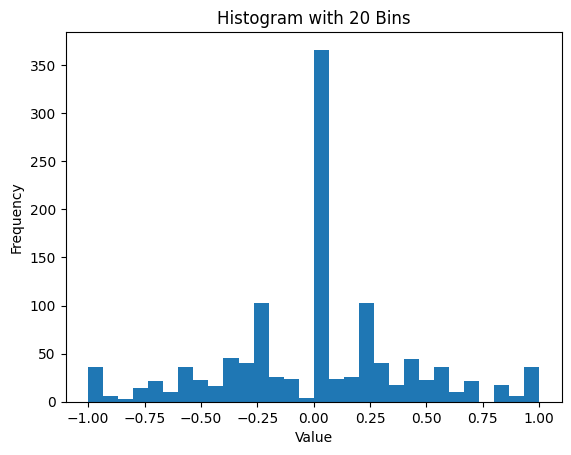

In [ ]:
plt.hist(y, bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram with 20 Bins")
plt.show()

## 3. Model Training & Validation

In [ ]:
# Split the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [ ]:
y_train

,Turn
1171,-0.14
18,-0.35
169,0.00
104,-0.70
560,-0.40
...,...
626,0.60
1016,0.67
165,-0.20
7,-0.25


In [ ]:
k = 30
k_best = SelectKBest(score_func=f_classif, k=k)
k_best.fit(X_train, y_train)

selected_feature_indices = k_best.get_support(indices=True)
print("selected_feature_indices: ", selected_feature_indices)

selected_feature_indices:  [ 36  37  38  39  40  41  42  43  44  45  46  47  48 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328]


In [ ]:
# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
# Train the model on the training data
rf.fit(X_train.iloc[:, selected_feature_indices], y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
X_test.iloc[:, selected_feature_indices].shape

(295, 30)

In [ ]:
# Make predictions on the testing data
y_pred = rf.predict(X_test.iloc[:, selected_feature_indices])

In [ ]:
# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.049256583830508474


In [ ]:
# Calculate the R-squared value of the predictions
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.7074573093820301


## 4. Export the Model

In [ ]:
import pickle
# Save the model to disk
filename = 'self_driving_model_0.2.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf, file)

# 5. Deploy the model into ROS Robot

In [ ]:
# prompt: Deploy the model  into ROS Robot

import rospy
from sensor_msgs.msg import LaserScan
from std_msgs.msg import Float64
import numpy as np
import pickle

# Load the trained model
with open('self_driving_model_0.2.pkl', 'rb') as file:
    model = pickle.load(file)

# Define the selected feature indices (same as used during training)
selected_feature_indices = [  # Replace with the actual indices from your training
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29
]

# Initialize ROS node
rospy.init_node('lidar_model_node')

# Create publisher for steering angle
steering_pub = rospy.Publisher('/steering_angle', Float64, queue_size=10)

def lidar_callback(data):
    # Extract LIDAR data (replace with actual data handling)
    lidar_data = np.array(data.ranges)

    # Preprocess the lidar data (similar to your training preprocessing)
    # For example, handle invalid readings (NaN, inf), clipping, or zero distances

    # Select the relevant features
    processed_lidar_data = lidar_data[selected_feature_indices]

    # Reshape to match the model input
    input_data = processed_lidar_data.reshape(1, -1)

    # Predict the steering angle
    steering_angle = model.predict(input_data)[0]

    # Publish the steering angle
    steering_msg = Float64()
    steering_msg.data = steering_angle
    steering_pub.publish(steering_msg)


# Subscribe to the LIDAR topic
rospy.Subscriber('/scan', LaserScan, lidar_callback)

# Keep the node running
rospy.spin()
